### Mount drive and import libraries

In [31]:
# Uncomment if pysteps is not installed
!pip install pysteps


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, TensorDataset
from pysteps.utils import spectral
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import kagglehub


### Move to GPU

In [32]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


### Parameters

In [33]:
# To be modified or enhanced
batch_size = 32
num_epochs = 2
learning_rate = 0.001
rapsd_dim = 16*3
n_classes = 2
rapsd_encoder_dim = 32



### Functions

In [34]:
# Function to prepare image for fft
def prepare_image_for_fft(image):

    # Convert to numpy array
    image_np = image.cpu().numpy()
    return image_np

In [35]:
def compute_rapsd_subset(subset):
    """
    Computes RAPSD for a subset of images.

    Parameters:
    - subset: List or dataset of (image, label) pairs.

    Returns:
    - List of merged RAPSD features for each image.
    - List of frequency arrays for each image.
    """
    rapsd_subset = []
    frequencies_subset = []

    # For all images in subset
    for img, _ in subset:
        rapsd_features = []  # To store per-channel RAPSD for one image
        frequencies_list = []  # To store per-channel frequencies for one image

        # Iterate over each of the three channels (RGB)
        for i in range(img.shape[0]):  # Assuming the image is 3xHxW (3 channels)
            # Prepare the image
            prepared_image = prepare_image_for_fft(img[i])

            # Compute RAPSD
            rapsd, frequencies = spectral.rapsd(prepared_image, fft_method=np.fft, return_freq=True)
            rapsd_features.append(rapsd)
            frequencies_list.append(frequencies)

        # Merge RAPSD features for all channels of one image
        merged_rapsd = np.concatenate(rapsd_features, axis=0)  # Combine RAPSD features for all channels
        merged_frequencies = np.array(frequencies_list[0])  # Use frequencies from the first channel (identical)

        # Append per-image results
        rapsd_subset.append(merged_rapsd)
        frequencies_subset.append(merged_frequencies)

    return rapsd_subset, frequencies_subset

In [36]:
def accuracy(target, pred):
  target = target.detach().cpu().numpy()
  pred = pred.detach().cpu().numpy()
  return metrics.accuracy_score(target, pred)

In [37]:
def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(),
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

### Image preprocessing

In [38]:
# Uncomment if kagglehub is not installed
#!pip install kagglehub

In [39]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

visual_transform = transforms.Compose([
    transforms.ToTensor(),  # Only converts to tensor
])

# Download CIFAKE dataset (CIFAR-10 subset and synthetic versions of each image)
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")
print("Path to dataset files:", path)

cifake_images_path_test = path + "/test"
cifake_images_path_train = path + "/train"

# Load datasets CIFAKE train and test
cifake_dataset_train = datasets.ImageFolder(root=cifake_images_path_train, transform=transform)
cifake_dataset_test = datasets.ImageFolder(root=cifake_images_path_test, transform=transform)


# Train and val split
train_size = int(0.9 * len(cifake_dataset_train))
val_size = len(cifake_dataset_train) - train_size

train_dataset, val_dataset = random_split(cifake_dataset_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Test set
test_size = len(cifake_dataset_test)

test_loader = DataLoader(cifake_dataset_test, batch_size=batch_size, shuffle=False)


Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


### Early stoppage

In [40]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

### CNN Model utilizing RAPSD vector as feature

In [44]:
class Model(nn.Module):
    def __init__(self, n_classes, rapsd_dim, rapsd_encoder_dim=128):
        super().__init__()
        self.num_classes = n_classes

        # CNN for image processing
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.2)

        # RAPSD Encoder (FFN for flattened RAPSD input)
        self.rapsd_encoder = nn.Sequential(
            nn.Linear(rapsd_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, rapsd_encoder_dim),
            nn.ReLU()
        )

        # For combined features
        self.feature_dim = 128 * 4 * 4 + rapsd_encoder_dim
        self.fc = nn.Linear(self.feature_dim, n_classes)

    def forward(self, x, x_rapsd):

        # Process image features through CNN
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2, 2)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2, 2)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2, 2)
        x = self.dropout(x)

        # Flatten image features
        x = torch.flatten(x, 1)

        # Process RAPSD features through FFN
        x_rapsd = self.rapsd_encoder(x_rapsd)

        # Concatenate CNN features with encoded RAPSD features
        combined_features = torch.cat((x, x_rapsd), dim=1)

        # Fully Connected Layer
        x = self.fc(combined_features)

        return x


model = Model(n_classes,rapsd_dim)
#device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rapsd_encoder): Sequential(
    (0): Linear(in_features=48, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): ReLU()
  )
  (fc): Linear(in_features=2176, out_features=2, bias=True)
)


### Optimizer

In [45]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train

Step 100     training accuracy: 0.7546875
             validation accuracy: 0.8222
Step 200     training accuracy: 0.8303125
             validation accuracy: 0.8548
Step 300     training accuracy: 0.8503125
             validation accuracy: 0.8166
Step 400     training accuracy: 0.8521875
             validation accuracy: 0.828
Step 500     training accuracy: 0.868125
             validation accuracy: 0.8663
Step 600     training accuracy: 0.8540625
             validation accuracy: 0.9015
Step 700     training accuracy: 0.8884375
             validation accuracy: 0.9028
Step 800     training accuracy: 0.8840625
             validation accuracy: 0.9059
Step 900     training accuracy: 0.8825
             validation accuracy: 0.8751
Step 1000    training accuracy: 0.88
             validation accuracy: 0.9068
Step 1100    training accuracy: 0.8803125
             validation accuracy: 0.855
Step 1200    training accuracy: 0.8828125
             validation accuracy: 0.8617
Step 1300    tr

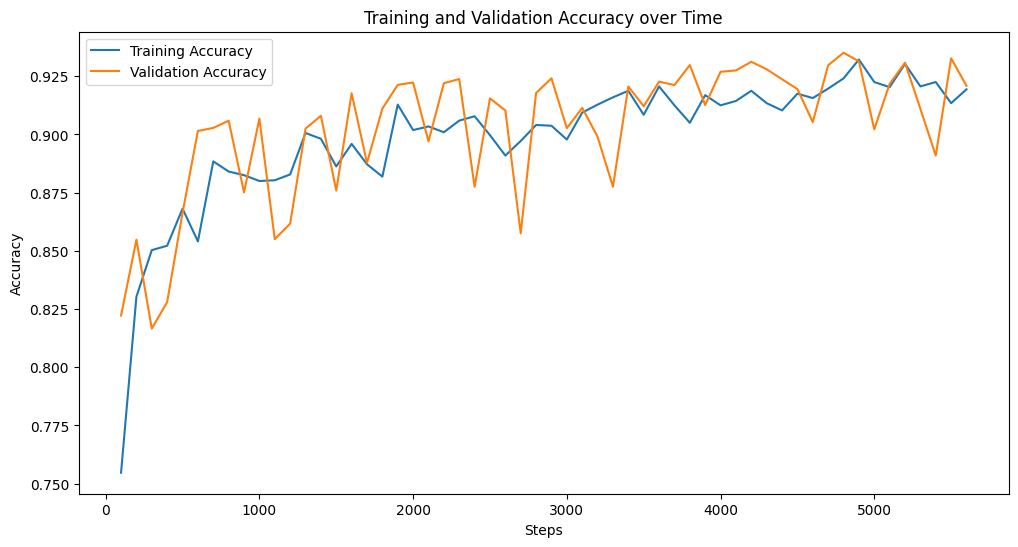

In [46]:
validation_every_steps = 100
step = 0

# Early stopping initialization
early_stopping = EarlyStopping(patience=5, delta=0.01)

model.train()

train_accuracies = []
valid_accuracies = []
steps_log = []  # Track steps for plotting
val_losses = []  # Initialize val_losses list to track validation loss

for epoch in range(num_epochs):

    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Compute RAPSD for the batch
        rapsd_vector_batch, _ = compute_rapsd_subset(zip(inputs.cpu(), targets.cpu()))

        # Convert the list of RAPSD vectors to a numpy array
        rapsd_vector_batch = np.array(rapsd_vector_batch)

        # Convert numpy array to PyTorch tensor
        rapsd_vector_batch = torch.from_numpy(rapsd_vector_batch).type(torch.float32).to(device)

        output = model(inputs, rapsd_vector_batch)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))

            train_accuracies_batches = []

            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            val_loss_total = 0  # Variable to accumulate the validation loss

            with torch.no_grad():
                model.eval()
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    rapsd_vector_batch, _ = compute_rapsd_subset(zip(inputs.cpu(), targets.cpu()))

                    # Convert the list of RAPSD vectors to a numpy array
                    rapsd_vector_batch = np.array(rapsd_vector_batch)

                    rapsd_vector_batch = torch.from_numpy(rapsd_vector_batch).type(torch.float32).to(device)

                    output = model(inputs, rapsd_vector_batch)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                    # Accumulate the loss
                    val_loss_total += loss.item() * len(inputs)  # Multiply by batch size to get total loss

                model.train()

            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / val_size)

            # Store the average validation loss for the entire validation set
            avg_val_loss = val_loss_total / val_size
            val_losses.append(avg_val_loss)

            steps_log.append(step)  # Track the step number for plotting

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             validation accuracy: {valid_accuracies[-1]}")

    # Pass the average validation loss for the current epoch to the early stopping
    early_stopping(val_losses[-1], model)  # Using the latest validation loss

    # Check if early stop
    if early_stopping.early_stop:
        print("Early stopping")
        break

early_stopping.load_best_model(model)

print("Finished training.")

# Plotting accuracy over training steps
plt.figure(figsize=(12, 6))
plt.plot(steps_log, train_accuracies, label='Training Accuracy')
plt.plot(steps_log, valid_accuracies, label='Validation Accuracy')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy over Time")
plt.legend()
plt.show()


### Test evaluation

In [49]:
# Evaluate model

with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        rapsd_vector_batch,_ = compute_rapsd_subset(zip(inputs.cpu(), targets.cpu()))
        rapsd_vector_batch = np.array(rapsd_vector_batch)

        rapsd_vector_batch = torch.from_numpy(rapsd_vector_batch).type(torch.float32).to(device)
        output = model(inputs,rapsd_vector_batch)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))


    test_accuracy = np.sum(test_accuracies) / test_size

    model.train()

print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.939


### CNN Model without RAPSD vector

In [53]:
class ModelCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.num_classes = n_classes
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.2)

        self.fc = nn.Linear(128*4*4, n_classes)

    def forward(self, x):

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x,2, 2)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x,2,2)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x,2,2)
        x = self.dropout(x)

        x = torch.flatten(x, 1)

        x = self.fc(x)

        return x


modelCNN = ModelCNN(n_classes)
modelCNN.to(device)
print(modelCNN)

ModelCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=2048, out_features=2, bias=True)
)


### Optimizer

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=learning_rate)

### Training

Step 100     training accuracy: 0.76125
             validation accuracy: 0.7836
Step 200     training accuracy: 0.7965625
             validation accuracy: 0.8572
Step 300     training accuracy: 0.8359375
             validation accuracy: 0.8664
Step 400     training accuracy: 0.8484375
             validation accuracy: 0.883
Step 500     training accuracy: 0.850625
             validation accuracy: 0.878
Step 600     training accuracy: 0.861875
             validation accuracy: 0.8896
Step 700     training accuracy: 0.868125
             validation accuracy: 0.901
Step 800     training accuracy: 0.873125
             validation accuracy: 0.9018
Step 900     training accuracy: 0.88
             validation accuracy: 0.8753
Step 1000    training accuracy: 0.8778125
             validation accuracy: 0.9052
Step 1100    training accuracy: 0.881875
             validation accuracy: 0.904
Step 1200    training accuracy: 0.89875
             validation accuracy: 0.8357
Step 1300    training 

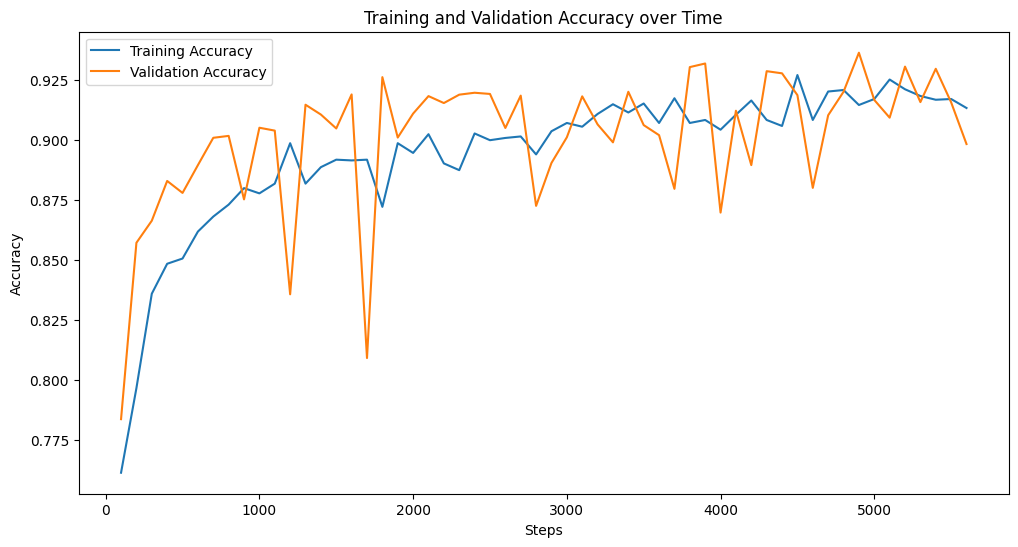

In [55]:
# Define the validation frequency and initialize the step counter
validation_every_steps = 100
step = 0

# Early stopping initialization
early_stopping = EarlyStopping(patience=5, delta=0.01)

modelCNN.train()

train_accuracies = []
valid_accuracies = []
steps_log = []  # Track steps for plotting
val_losses = []  # Initialize val_losses list to track validation loss

for epoch in range(num_epochs):

    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        output = modelCNN(inputs)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))

        if step % validation_every_steps == 0:

            # Append average training accuracy to list
            train_accuracies.append(np.mean(train_accuracies_batches))
            train_accuracies_batches = []

            # Compute accuracies on validation set
            valid_accuracies_batches = []
            val_loss_total = 0  # Variable to accumulate the validation loss

            with torch.no_grad():
                modelCNN.eval()
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    output = modelCNN(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                    # Accumulate the validation loss
                    val_loss_total += loss.item() * len(inputs)  # Multiply by batch size to get total loss

                modelCNN.train()

            # Append average validation accuracy to list
            valid_accuracies.append(np.sum(valid_accuracies_batches) / val_size)

            # Calculate and store the average validation loss
            avg_val_loss = val_loss_total / val_size
            val_losses.append(avg_val_loss)  # Store the average loss for this epoch

            steps_log.append(step)  # Track the step number for plotting

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             validation accuracy: {valid_accuracies[-1]}")

    # Early stopping based on validation loss
    early_stopping(val_losses[-1], modelCNN)

    # Check if early stopping is triggered
    if early_stopping.early_stop:
        print("Early stopping")
        break

early_stopping.load_best_model(modelCNN)

print("Finished training.")

# Plotting accuracy over training steps
plt.figure(figsize=(12, 6))
plt.plot(steps_log, train_accuracies, label='Training Accuracy')
plt.plot(steps_log, valid_accuracies, label='Validation Accuracy')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy over Time")
plt.legend()
plt.show()


### Test evaluation

In [56]:
# Evaluate test set

with torch.no_grad():
    modelCNN.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = modelCNN(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        test_accuracies.append(accuracy(targets, predictions) * len(inputs))


    test_accuracy = np.sum(test_accuracies) / test_size

    modelCNN.train()

print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.933


### Things to try
* Creating a specific encoder for RAPSD seperate and then combining with CNN
* Implementing a GRU or other RNN, LSTM for RAPSD
* Attention mechanism? Don't know if this is correct
* Test different datasets
* Focus solely on RAPSD as input?
* Saliency map?
* RGB channel for testing instead of grayscale